# **Classificatore forme**

---

## Importazione librerie necessarie

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.spatial import ConvexHull
from itertools import combinations
import pandas as pd

## Generazione singola forma

In [6]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

### Generazione Dataset


In [7]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        

    return np.array(X), np.array(y)  # restituisce array di campioni e etichette


* Otteniamo le features appiattite

In [8]:
def ottieni_features(X):
    return np.array([list(x.flatten()) for x in X])

In [9]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

In [10]:
X, y = genera_campioni(n_shapes=4000, n_punti=100, rumore_std_bound=0.00001)
X_flat = ottieni_features(X)

---

## Estrazione e valutazione di nuove features

In [ ]:
def extract_geometric_features(pts):
    """
    pts: array (n_punti, 2)
    Restituisce un dict con le feature geometriche.
    """
    # 1. Centroid
    cx, cy = pts.mean(axis=0)
    # distanze dal centroide
    dists = np.linalg.norm(pts - (cx, cy), axis=1)
    dist_mean = dists.mean()
    dist_std  = dists.std()

    # 2. Perimetro
    diffs = np.diff(pts, axis=0, append=pts[:1])
    perimeter = np.linalg.norm(diffs, axis=1).sum()

    # 3. Area (shoelace)
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    # 4. Bounding-box aspect ratio
    minx, maxx = x.min(), x.max()
    miny, maxy = y.min(), y.max()
    width, height = maxx - minx, maxy - miny
    aspect_ratio = width / height if height>0 else 0

    # 5. Extreme distances
    # (costo O(n^2), per n~100 va bene)
    dists_all = [np.linalg.norm(p-q) for p, q in combinations(pts, 2)]
    d_max = max(dists_all)
    d_min = min(dists_all)

    # 6. Convex hull
    hull = ConvexHull(pts)
    hull_area = hull.volume    # in 2D volume è l’area
    hull_perim = hull.area     # in 2D area è il perimetro dell’inviluppo
    hull_ratio = area / hull_area if hull_area>0 else 0

    # 7. Compactness
    compactness = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0

    # 8. Eccentricity (PCA sui punti)
    # calcolo cov e autovalori
    cov = np.cov(pts.T)
    evals, _ = np.linalg.eig(cov)
    # rapport tra max e min asse
    ecc = np.sqrt(evals.max()/evals.min()) if evals.min()>0 else 0
    

In [11]:
X_flat = np.array([shape.flatten() for shape in X])

# 2) Genera i nomi delle colonne: x0,y0,x1,y1,…,x{n_punti-1},y{n_punti-1}
n_punti = X.shape[1]
cols_xy = []
for i in range(n_punti):
    cols_xy += [f'x{i}', f'y{i}']

# 3) Costruisci df_flat e assegna la label
df_flat = pd.DataFrame(X_flat, columns=cols_xy)  

# Controlla
print(df_flat.shape)   # (n_shapes, 200+1)
print(df_flat.head())

(16000, 200)
         x0        y0        x1        y1        x2        y2        x3  \
0  0.328890 -3.261693  0.286912 -3.270564  0.245711 -3.283209  0.205484   
1 -3.218561 -0.555717 -3.095255 -0.551595 -2.972428 -0.538713 -2.850574   
2 -1.191652  5.522692 -1.353917  5.483894 -1.513317  5.434381 -1.669200   
3 -2.585368 -4.201506 -2.565535 -4.119648 -2.554694 -4.035427 -2.552890   
4 -0.826236 -2.119932 -0.883051 -2.104250 -0.940973 -2.092850 -0.999770   

         y3        x4        y4  ...       x95       y95       x96       y96  \
0 -3.299549  0.166367 -3.319550  ...  0.501402 -3.264314  0.457949 -3.257911   
1 -0.517131 -2.730182 -0.486928  ... -3.706640 -0.484831 -3.586380 -0.515552   
2  5.374345 -1.820938  5.304026  ... -0.527017  5.568157 -0.694174  5.573379   
3 -3.949164 -2.560095 -3.861253  ... -2.752284 -4.499084 -2.697705 -4.429791   
4 -2.085776 -1.059204 -2.083058  ... -0.614543 -2.223953 -0.664698 -2.191946   

        x97       y97       x98       y98       x99    

In [71]:
features_list = []
for shape in X:
    feats = extract_geometric_features(shape)  # dict delle nuove feature
    features_list.append(feats)

In [12]:
df_geo = pd.DataFrame(features_list)
df_geo['label'] = y 

NameError: name 'features_list' is not defined

In [73]:
df_all = pd.concat([df_flat, df_geo], axis=1)
print(df_all.shape)

(16000, 213)


In [74]:
df_all.to_csv('dataset_geometric_features.csv', index=False)

---

## Splitting del dataset

Creiamo un set per: 
* `train`
* `validation`
* `test`


In [15]:
# 1) Split iniziale: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Split secondario: train vs validation (da quel 80% rimasto, 80% train e 20% validation → 64% train, 16% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)


**Ognuno con le rispettive percentuali più opportune**

In [16]:
print("Shape di X:", X_train.shape)
print("Shape di y:", y.shape)

Shape di X: (10240, 200)
Shape di y: (16000,)


---

## Metodo PCA e valutazione

* Prepariamo le funzioni che servono all'applicazione della PCA

In [17]:
def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

* Applichiamo la PCA a tutti i dataset splittati con un numero di componenti = 20

In [18]:
numpc = 20

autovalori_test, autovettori_test, M_test = get_eigen(X_test)
base_test, proiezioni_test = pca(M_test, autovettori_test, numpc=numpc)

transformed_test_set = proiezioni_test.dot(base_test.T)

autovalori_train, autovettori_train, M_train = get_eigen(X_train)
base_train, proiezioni_train = pca(M_train, autovettori_train, numpc=numpc)

transformed_train_set = proiezioni_train.dot(base_train.T)

autovalori_val, autovettori_val, M_val = get_eigen(X_val)
base_val, proiezioni_val = pca(M_val, autovettori_train, numpc=numpc)

transformed_train_set = proiezioni_train.dot(base_val.T)

In [20]:
var_ratio = autovalori_train / autovalori_train.sum()
print("Total explained variance (%d):" % numpc, var_ratio[:numpc].sum())

Total explained variance (20): 0.9999982837301072


* Ciò permette di avere con la sola proiezione di 20 componentei una varianza di `0.99`, una ricostruzione quasi perfetta delle forme

* Disegno:

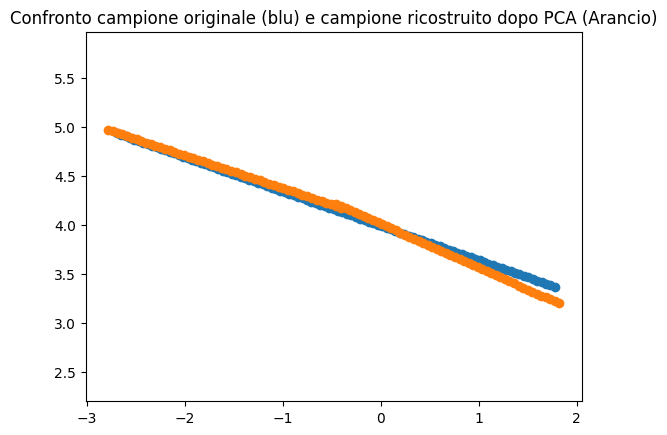

In [32]:

i = np.random.randint(low=1, high=4000)

projected = proiezioni_train.dot(base_train.T)
projected_example_train = projected[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo PCA (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

---

## Feature selection


* Sia gli alberi decisionali singoli (Decision Tree) sia gli ensemble basati su di essi (Random Forest) forniscono automaticamente una misura di importanza di ciascuna feature
* Utilizziamo Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

* Dopo aver addestrato il modello sul train set, otteniamo le features più importanti, ottenute automaticamente dall'addestramento stesso

In [35]:
importances_rf = rf.feature_importances_

* Con questo metodo calcoliamo la soglia basata sul `percentile`:

Percentile 10% → trattandosi di 10 componenti, il 10° percentile corrisponde all’importanza del secondo elemento ordinato;
quindi mantieni le componenti dall’indice del 2° valore in poi (top 8 su 10 = 80 %).
e

In [ ]:
threshold = np.percentile(importances_rf, 10)  # top 90%
mask = importances_rf >= threshold
print("Componenti mantenute:", np.where(mask)[0]) #Indicizzazione X[:, mask] filtra le colonne, riducendo dimensionalità e mantenendo solo quelle ritenute “importanti”.
X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:,  mask]

NameError: name 'importances_rf' is not defined

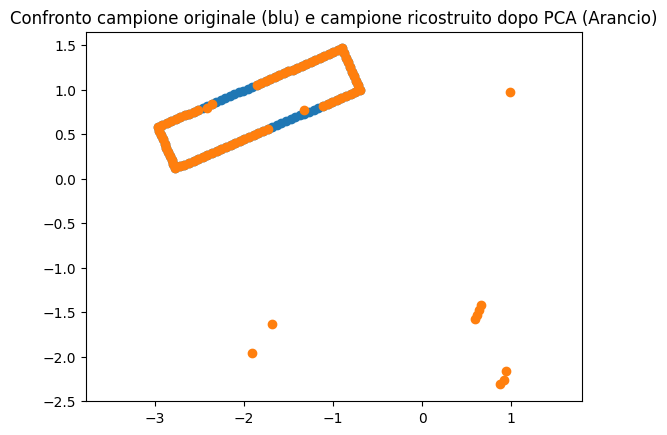

In [ ]:
i = np.random.randint(low=1, high=4000)

projected_example_train = X_train_sel[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo feature selection (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)